> **Name:** Shashaank Singh <br>
> **Registration Number:** 220968310 <br>
> **Roll Number:** 47 <br>
> **Batch:** A2 <br>
> **Week:** 11

### Required Imports

In [1]:
from itertools import product

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

Use the Taxi v3 environment:<br>
https://gymnasium.farama.org/environments/toy_text/taxi

In [27]:
env: gym.Env = gym.make("Taxi-v3")#, render_mode="human")
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>>

_Resetting environment:_

In [28]:
env.reset()

(8, {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)})

_Observation Space:_

In [4]:
env.observation_space

Discrete(500)

_The environment looks like this with 25 taxi positions, 5 passenger positions (4 on one of the squares, and 1 inside the taxi) and 4 destinations, leading to 25 * 5 * 4 = 500 states:_

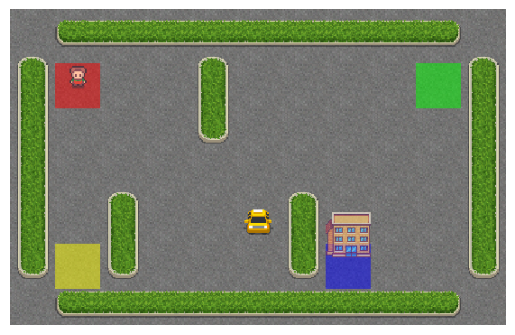

In [5]:
temp: gym.Env = gym.make("Taxi-v3", render_mode="rgb_array")
temp.reset()
plt.axis(False)
plt.imshow(temp.render())
del temp

_Finding all states where the episode will end:_

In [6]:
# We will set all those states' qualities to 0
# where passenger position = destination cuz it's terminal
# State = ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
term_states: list[int] = [((i * 5 + j) * 5 + k) * 4 + k for i, j, k in product(range(5), range(5), range(4))]
term_states

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170,
 175,
 180,
 185,
 190,
 195,
 200,
 205,
 210,
 215,
 220,
 225,
 230,
 235,
 240,
 245,
 250,
 255,
 260,
 265,
 270,
 275,
 280,
 285,
 290,
 295,
 300,
 305,
 310,
 315,
 320,
 325,
 330,
 335,
 340,
 345,
 350,
 355,
 360,
 365,
 370,
 375,
 380,
 385,
 390,
 395,
 400,
 405,
 410,
 415,
 420,
 425,
 430,
 435,
 440,
 445,
 450,
 455,
 460,
 465,
 470,
 475,
 480,
 485,
 490,
 495]

_Action space:_

In [7]:
env.action_space

Discrete(6)

_There are 6 possible actions, with the corresponding update to the environment:_
- _`0`: Move south (down)_
- _`1`: Move north (up)_
- _`2`: Move east (right)_
- _`3`: Move west (left)_
- _`4`: Pickup passenger_
- _`5`: Drop off passenger_

Learn the policy using the following algorithms (Let parameters α = 0.4, γ = 0.9, Ɛ = 0.9):

In [8]:
num_episodes: int = 2000

# Extra variables
alpha: float = .4
gamma: float = .9
epsilon_max: float = .9
epsilon_min: float = .1

1. SARSA

_Initializing Q:_

In [9]:
"""Q_s: np.ndarray = np.full(
    (env.observation_space.n, env.action_space.n),
    1. / env.action_space.n
)"""
Q_s: np.ndarray = np.random.random(
    (env.observation_space.n, env.action_space.n)
)
Q_s[term_states] = 0
Q_s

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.86839042, 0.05456327, 0.8904025 , 0.29337637, 0.29620037,
        0.28581058],
       [0.65926961, 0.14729372, 0.64713409, 0.93666763, 0.62028086,
        0.63865477],
       ...,
       [0.06054384, 0.2146838 , 0.47673891, 0.52275959, 0.40083797,
        0.42686566],
       [0.05230398, 0.33480485, 0.67114141, 0.00180577, 0.33405133,
        0.62862769],
       [0.25668256, 0.73879688, 0.04297123, 0.70084448, 0.55597568,
        0.49276135]], shape=(500, 6))

_Modified version with action masks:_

In [10]:
Q_sm: np.ndarray = np.random.random(
    (env.observation_space.n, env.action_space.n)
)
for i in range(env.observation_space.n):
    Q_sm[i, np.bitwise_not(env.unwrapped.action_mask(i).astype(bool))] = 0
Q_sm[term_states] = 0
Q_sm

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.90087275, 0.        , 0.79262251, 0.        , 0.40567872,
        0.        ],
       [0.96101052, 0.        , 0.92619338, 0.        , 0.8637163 ,
        0.        ],
       ...,
       [0.        , 0.60251648, 0.        , 0.85959214, 0.        ,
        0.        ],
       [0.        , 0.1300569 , 0.        , 0.89703911, 0.        ,
        0.        ],
       [0.        , 0.9659535 , 0.        , 0.80045419, 0.        ,
        0.        ]], shape=(500, 6))

_Training Run (With Ɛ decay):_

In [11]:
ep: float = epsilon_max # Initializing here for Ɛ decay
train_s_rewards: list[float] = []
terms: int = 0 # How many episodes ended with dropping the passenger?
truncs: int = 0 # How many episodes timed out?
# Loop for each episode
for episode in range(num_episodes):
    # Initialize S
    S, _ = env.reset()
    # Choose A from S using policy derived from Q
    if np.random.rand() < ep: # (with Ɛ-greedy)
        A: int = env.action_space.sample()
        #print(f"[Episode {episode}] Epsilon activated, sampled action: {A}")
    else:
        A: int = np.random.choice(np.argwhere(
            Q_s[S] == Q_s[S].max()
        ).flatten())
    terminated = truncated = False
    reward = 0.
    # Loop for each step of episode
    while not terminated and not truncated:
        # Take action A, observe R, S'
        obs, R, terminated, truncated, _ = env.step(A)
        reward += R # Storing episode rewards
        # Choose A' from S' using policy derived from Q
        if np.random.rand() < ep: # (with Ɛ-greedy)
            # A <- A' (to prevent unnecessary variable)
            A = env.action_space.sample()
            #print(f"[Episode {episode}] Epsilon activated, sampled action: {A}")
        else:
            # A <- A' (to prevent unnecessary variable)
            A = np.random.choice(np.argwhere(
                Q_s[obs] == Q_s[obs].max()
            ).flatten())
        # Q(S,A) <- Q(S,A) + α[R + γQ(S',A') - Q(S,A)]
        Q_s[S, env.unwrapped.lastaction] += alpha * (R + gamma * Q_s[obs, A] 
            - Q_s[S, env.unwrapped.lastaction])
        # S <- S'
        S = obs
    train_s_rewards.append(reward)
    if terminated:
        terms += 1
    else:
        truncs += 1
    print(f"[Episode {episode}] Ɛ={ep}, {'terminated' if terminated else 'truncated'} with reward {reward}.")
    # Ɛ decay with increasing episodes
    ep -= (epsilon_max - epsilon_min) * 1. / num_episodes

Q_s, terms, truncs, train_s_rewards

[Episode 0] Ɛ=0.1, truncated with reward -821.0.
[Episode 1] Ɛ=0.1, truncated with reward -830.0.
[Episode 2] Ɛ=0.1, truncated with reward -767.0.
[Episode 3] Ɛ=0.1, truncated with reward -713.0.
[Episode 4] Ɛ=0.1, truncated with reward -686.0.
[Episode 5] Ɛ=0.1, truncated with reward -713.0.
[Episode 6] Ɛ=0.1, truncated with reward -704.0.
[Episode 7] Ɛ=0.1, truncated with reward -533.0.
[Episode 8] Ɛ=0.1, truncated with reward -911.0.
[Episode 9] Ɛ=0.1, truncated with reward -794.0.
[Episode 10] Ɛ=0.1, truncated with reward -461.0.
[Episode 11] Ɛ=0.1, truncated with reward -533.0.
[Episode 12] Ɛ=0.1, truncated with reward -452.0.
[Episode 13] Ɛ=0.1, truncated with reward -425.0.
[Episode 14] Ɛ=0.1, truncated with reward -596.0.
[Episode 15] Ɛ=0.1, truncated with reward -254.0.
[Episode 16] Ɛ=0.1, terminated with reward -165.0.
[Episode 17] Ɛ=0.1, truncated with reward -785.0.
[Episode 18] Ɛ=0.1, terminated with reward -334.0.
[Episode 19] Ɛ=0.1, truncated with reward -776.0.
[Episode

(array([[  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [ -5.68461258,  -5.75611011,  -5.86423915,  -5.49261832,
          -3.06285517, -11.9741116 ],
        [ -2.33658733,   0.52530254,  -3.29508852,  -1.4166667 ,
           5.49235581,  -7.0515812 ],
        ...,
        [ -2.50387613,  -3.07554976,  -2.39827434,   2.55807796,
          -6.09183116,  -6.00982371],
        [ -3.36869043,  -0.42223525,  -3.19960068,  -4.03310338,
          -6.20693636,  -5.91738071],
        [  0.25668256,   5.27648806,   0.04297123,  16.16385267,
           2.13705489,   0.49276135]], shape=(500, 6)),
 3836,
 164,
 [-821.0,
  -830.0,
  -767.0,
  -713.0,
  -686.0,
  -713.0,
  -704.0,
  -533.0,
  -911.0,
  -794.0,
  -461.0,
  -533.0,
  -452.0,
  -425.0,
  -596.0,
  -254.0,
  -165.0,
  -785.0,
  -334.0,
  -776.0,
  -299.0,
  -299.0,
  -803.0,
  -308.0,
  -362.0,
  -488.0,
  -219.0,
  -416.0,
  -380.0,
  -245.0,
  -380.0,
  -299.0,
  -443.0,
  -171.0

_Modified version taking action masks into account:_

In [12]:
ep: float = epsilon_max # Initializing here for Ɛ decay
train_sm_rewards: list[float] = []
terms: int = 0 # How many episodes ended with dropping the passenger?
truncs: int = 0 # How many episodes timed out?
# Loop for each episode
for episode in range(num_episodes):
    # Initialize S
    S, info = env.reset()
    # Choose A from S using policy derived from Q
    if np.random.rand() < ep: # (with Ɛ-greedy)
        A: int = env.action_space.sample(info["action_mask"])
        #print(f"[Episode {episode}] Epsilon activated, sampled action: {A}")
    else:
        A: int = np.random.choice(np.argwhere(
            Q_sm[S] == Q_sm[S].max()
        ).flatten())
    terminated = truncated = False
    reward = 0.
    # Loop for each step of episode
    while not terminated and not truncated:
        # Take action A, observe R, S'
        obs, R, terminated, truncated, info = env.step(A)
        reward += R # Storing episode rewards
        # Choose A' from S' using policy derived from Q
        if np.random.rand() < ep: # (with Ɛ-greedy)
            # A <- A' (to prevent unnecessary variable)
            A = env.action_space.sample()
            #print(f"[Episode {episode}] Epsilon activated, sampled action: {A}")
        else:
            # A <- A' (to prevent unnecessary variable)
            A = np.random.choice(np.argwhere(
                Q_sm[obs] == Q_sm[obs].max()
            ).flatten())
        # Q(S,A) <- Q(S,A) + α[R + γQ(S',A') - Q(S,A)]
        Q_sm[S, env.unwrapped.lastaction] += alpha * (R + gamma * Q_sm[obs, A] 
            - Q_sm[S, env.unwrapped.lastaction])
        # S <- S'
        S = obs
    train_sm_rewards.append(reward)
    if terminated:
        terms += 1
    else:
        truncs += 1
    print(f"[Episode {episode}] Ɛ={ep}, {'terminated' if terminated else 'truncated'} with reward {reward}.")
    # Ɛ decay with increasing episodes
    ep -= (epsilon_max - epsilon_min) * 1. / num_episodes

Q_sm, terms, truncs, train_sm_rewards

[Episode 0] Ɛ=0.1, terminated with reward -390.0.
[Episode 1] Ɛ=0.1, truncated with reward -434.0.
[Episode 2] Ɛ=0.1, truncated with reward -587.0.
[Episode 3] Ɛ=0.1, truncated with reward -767.0.
[Episode 4] Ɛ=0.1, terminated with reward -300.0.
[Episode 5] Ɛ=0.1, truncated with reward -542.0.
[Episode 6] Ɛ=0.1, truncated with reward -569.0.
[Episode 7] Ɛ=0.1, truncated with reward -542.0.
[Episode 8] Ɛ=0.1, truncated with reward -704.0.
[Episode 9] Ɛ=0.1, truncated with reward -479.0.
[Episode 10] Ɛ=0.1, terminated with reward -402.0.
[Episode 11] Ɛ=0.1, truncated with reward -299.0.
[Episode 12] Ɛ=0.1, terminated with reward -432.0.
[Episode 13] Ɛ=0.1, truncated with reward -695.0.
[Episode 14] Ɛ=0.1, truncated with reward -407.0.
[Episode 15] Ɛ=0.1, truncated with reward -560.0.
[Episode 16] Ɛ=0.1, truncated with reward -416.0.
[Episode 17] Ɛ=0.1, truncated with reward -614.0.
[Episode 18] Ɛ=0.1, truncated with reward -362.0.
[Episode 19] Ɛ=0.1, truncated with reward -650.0.
[Episo

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-6.77236656e+00, -6.56728047e+00, -8.24164295e+00,
         -8.94906493e+00, -1.44975357e+00, -1.43602482e+01],
        [-3.12201533e+00,  1.76336287e+00, -1.68362304e+00,
          9.52579481e-01,  7.11762392e+00, -5.48597018e+00],
        ...,
        [-2.87460861e-01,  1.36471912e-02, -4.82967720e-01,
         -9.86177430e-02, -8.12612796e+00, -4.00000000e+00],
        [-3.76285973e+00,  6.30889129e-01, -3.29727516e+00,
         -4.92996656e+00, -6.40000000e+00, -1.07791348e+01],
        [ 5.71266031e+00, -2.25321322e-01, -3.71101895e-01,
          1.69999979e+01,  0.00000000e+00,  0.00000000e+00]],
       shape=(500, 6)),
 3822,
 178,
 [-390.0,
  -434.0,
  -587.0,
  -767.0,
  -300.0,
  -542.0,
  -569.0,
  -542.0,
  -704.0,
  -479.0,
  -402.0,
  -299.0,
  -432.0,
  -695.0,
  -407.0,
  -560.0,
  -416.0,
  -614.0,
  -362.0,
  -650.0,
  -272.0,
  -542.0,
  -

_Testing run: (Without Ɛ decay and a small Ɛ value)_

In [29]:
test_s_rewards: list[float] = []
terms: int = 0 # How many episodes ended with dropping the passenger?
truncs: int = 0 # How many episodes timed out?
# Loop for each episode
for episode in range(num_episodes):
    # Initialize S
    S, _ = env.reset()
    terminated = truncated = False
    reward = 0.
    # Loop for each step of episode
    while not terminated and not truncated:
        # Choose A' from S' using policy derived from Q
        A = np.random.choice(np.argwhere(
            Q_s[S] == Q_s[S].max()
        ).flatten())
        S, R, terminated, truncated, _ = env.step(A)
        reward += R # Storing episode rewards
    test_s_rewards.append(reward)
    if terminated:
        terms += 1
    else:
        truncs += 1
    print(f"[Episode {episode}] {'terminated' if terminated else 'truncated'} with reward {reward}.")

terms, truncs, test_s_rewards

[Episode 0] terminated with reward 9.0.
[Episode 1] terminated with reward 14.0.
[Episode 2] terminated with reward 7.0.
[Episode 3] terminated with reward 9.0.
[Episode 4] terminated with reward 6.0.


(5, 0, [])

_Modified w/ action masks:_

In [30]:
test_sm_rewards: list[float] = []
terms: int = 0 # How many episodes ended with dropping the passenger?
truncs: int = 0 # How many episodes timed out?
# Loop for each episode
for episode in range(num_episodes):
    # Initialize S
    S, _ = env.reset()
    terminated = truncated = False
    reward = 0.
    # Loop for each step of episode
    while not terminated and not truncated:
        # Choose A' from S' using policy derived from Q
        A = np.random.choice(np.argwhere(
            Q_sm[S] == Q_sm[S].max()
        ).flatten())
        S, R, terminated, truncated, _ = env.step(A)
        reward += R # Storing episode rewards
    test_sm_rewards.append(reward)
    if terminated:
        terms += 1
    else:
        truncs += 1
    print(f"[Episode {episode}] {'terminated' if terminated else 'truncated'} with reward {reward}.")

terms, truncs, test_sm_rewards

[Episode 0] truncated with reward -200.0.
[Episode 1] terminated with reward 11.0.
[Episode 2] truncated with reward -200.0.
[Episode 3] truncated with reward -200.0.
[Episode 4] terminated with reward 7.0.


(2, 3, [])

2. Expected SARSA

_Initializing Q:_

In [15]:
"""Q_es: np.ndarray = np.full(
    (env.observation_space.n, env.action_space.n),
    1. / env.action_space.n
)"""
Q_es: np.ndarray = np.random.random(
    (env.observation_space.n, env.action_space.n)
)
Q_es[term_states] = 0
Q_es

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.58362177e-01, 9.73455779e-01, 4.28791827e-01, 4.81038006e-01,
        1.19099825e-01, 1.11517810e-02],
       [9.63721897e-01, 9.35988687e-01, 1.20880504e-04, 2.13351577e-01,
        1.95543466e-01, 7.99040227e-01],
       ...,
       [6.87923546e-01, 6.32886984e-01, 8.38688711e-01, 6.94543557e-01,
        4.09022440e-01, 7.59956777e-01],
       [4.93727112e-01, 1.87106791e-02, 5.03091965e-01, 6.06395201e-01,
        5.36665987e-01, 8.96379660e-01],
       [4.53727048e-01, 8.99725110e-01, 4.40805168e-01, 5.98533851e-01,
        1.43102833e-01, 5.49317550e-01]], shape=(500, 6))

_Modified version with action masks:_

In [16]:
Q_esm: np.ndarray = np.random.random(
    (env.observation_space.n, env.action_space.n)
)
for i in range(env.observation_space.n):
    Q_esm[i, np.bitwise_not(env.unwrapped.action_mask(i).astype(bool))] = 0
Q_esm[term_states] = 0
Q_esm

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.71143693, 0.        , 0.78868515, 0.        , 0.50332291,
        0.        ],
       [0.76135021, 0.        , 0.90379681, 0.        , 0.52427787,
        0.        ],
       ...,
       [0.        , 0.54070589, 0.        , 0.17244604, 0.        ,
        0.        ],
       [0.        , 0.95218286, 0.        , 0.20493064, 0.        ,
        0.        ],
       [0.        , 0.20620512, 0.        , 0.03857502, 0.        ,
        0.        ]], shape=(500, 6))

_Training Run (With Ɛ decay):_

In [17]:
ep: float = epsilon_max # Initializing here for Ɛ decay
train_es_rewards: list[float] = []
terms: int = 0 # How many episodes ended with dropping the passenger?
truncs: int = 0 # How many episodes timed out?
# Loop for each episode
for episode in range(num_episodes):
    # Initialize S
    S, _ = env.reset()
    terminated = truncated = False
    reward = 0.
    # Loop for each step of episode
    while not terminated and not truncated:
        # Choose A from S using policy derived from Q
        if np.random.rand() < ep: # (with Ɛ-greedy)
            A = env.action_space.sample()
            #print(f"[Episode {episode}] Epsilon activated, sampled action: {A}")
        else:
            A = np.random.choice(np.argwhere(
                Q_es[S] == Q_es[S].max()
            ).flatten())
        # Take action A, observe R, S'
        obs, R, terminated, truncated, _ = env.step(A)
        reward += R # Storing episode rewards
        # π(a|S') = Ɛ / |A(s)| if non optimal action
        pi: np.ndarray = np.full(env.action_space.n, ep / env.action_space.n)
        # Find all optimal actions
        cond: np.ndarray = Q_es[obs] == Q_es[obs].max()
        # else (1 - Ɛ) / (no. of optimal actions) + Ɛ / |A(s)|
        pi[cond] += (1 - ep) / np.count_nonzero(cond)
        # Q(S,A) <- Q(S,A) + α[R + γΣπ(a|S')Q(S',a) - Q(S,A)]
        Q_es[S, A] += alpha * (R + gamma * np.dot(pi, Q_es[obs])
            - Q_es[S, A])
        # S <- S'
        S = obs
    train_es_rewards.append(reward)
    if terminated:
        terms += 1
    else:
        truncs += 1
    print(f"[Episode {episode}] Ɛ={ep}, {'terminated' if terminated else 'truncated'} with reward {reward}.")
    # Ɛ decay with increasing episodes
    ep -= (epsilon_max - epsilon_min) * 1. / num_episodes

Q_es, terms, truncs, train_es_rewards

[Episode 0] Ɛ=0.1, truncated with reward -569.0.
[Episode 1] Ɛ=0.1, truncated with reward -506.0.
[Episode 2] Ɛ=0.1, terminated with reward -364.0.
[Episode 3] Ɛ=0.1, truncated with reward -614.0.
[Episode 4] Ɛ=0.1, truncated with reward -677.0.
[Episode 5] Ɛ=0.1, truncated with reward -560.0.
[Episode 6] Ɛ=0.1, truncated with reward -461.0.
[Episode 7] Ɛ=0.1, truncated with reward -605.0.
[Episode 8] Ɛ=0.1, truncated with reward -380.0.
[Episode 9] Ɛ=0.1, terminated with reward -383.0.
[Episode 10] Ɛ=0.1, truncated with reward -560.0.
[Episode 11] Ɛ=0.1, truncated with reward -416.0.
[Episode 12] Ɛ=0.1, truncated with reward -560.0.
[Episode 13] Ɛ=0.1, truncated with reward -245.0.
[Episode 14] Ɛ=0.1, truncated with reward -299.0.
[Episode 15] Ɛ=0.1, truncated with reward -488.0.
[Episode 16] Ɛ=0.1, truncated with reward -272.0.
[Episode 17] Ɛ=0.1, truncated with reward -632.0.
[Episode 18] Ɛ=0.1, truncated with reward -353.0.
[Episode 19] Ɛ=0.1, truncated with reward -515.0.
[Episode

(array([[  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [ -3.68135173,  -2.67997073,  -3.73534348,  -2.55148969,
          -1.17121167, -11.15016936],
        [  1.39879133,   3.32687048,   1.3881292 ,   3.08654716,
           5.55100586,  -5.47306776],
        ...,
        [ -2.17698166,   7.47133375,  -2.05415854,  -2.00203622,
          -3.63325473,  -3.27629942],
        [ -3.81347544,  -2.26462116,  -3.82830206,  -3.6298099 ,
          -7.3960258 ,  -7.03163826],
        [ -0.43919516,   3.16588764,  -0.45538171,  16.48087167,
          -3.88991512,  -3.47976709]], shape=(500, 6)),
 3936,
 64,
 [-569.0,
  -506.0,
  -364.0,
  -614.0,
  -677.0,
  -560.0,
  -461.0,
  -605.0,
  -380.0,
  -383.0,
  -560.0,
  -416.0,
  -560.0,
  -245.0,
  -299.0,
  -488.0,
  -272.0,
  -632.0,
  -353.0,
  -515.0,
  -470.0,
  -266.0,
  -308.0,
  -506.0,
  -68.0,
  -292.0,
  -254.0,
  -245.0,
  -184.0,
  -344.0,
  -228.0,
  -236.0,
  -290.0,
  -212.0,


_Modified version taking action masks into account:_

In [18]:
ep: float = epsilon_max # Initializing here for Ɛ decay
train_esm_rewards: list[float] = []
terms: int = 0 # How many episodes ended with dropping the passenger?
truncs: int = 0 # How many episodes timed out?
# Loop for each episode
for episode in range(num_episodes):
    # Initialize S
    S, info = env.reset()
    terminated = truncated = False
    reward = 0.
    # Loop for each step of episode
    while not terminated and not truncated:
        # Choose A from S using policy derived from Q
        if np.random.rand() < ep: # (with Ɛ-greedy)
            A = env.action_space.sample(info["action_mask"])
            #print(f"[Episode {episode}] Epsilon activated, sampled action: {A}")
        else:            
            A = np.random.choice(np.argwhere(
                Q_esm[S] == Q_esm[S].max()
            ).flatten())
        # Take action A, observe R, S'
        obs, R, terminated, truncated, info = env.step(A)
        reward += R # Storing episode rewards
        pi: np.ndarray = np.zeros(env.action_space.n)
        # π(a|S') = Ɛ / |A(s)| if non optimal action
        pi[info["action_mask"].astype("bool")] = ep / np.count_nonzero(info["action_mask"])
        # Find all optimal actions
        # ----------------------------------------------------
        # The reason we don't constrain this to mask
        # is that during initialization we already did that
        # and the only case where the max can be outside the
        # mask is a goal state which we don't care about cuz
        # the Q values for it are already zero
        # ----------------------------------------------------
        cond: np.ndarray = Q_esm[obs] == Q_esm[obs].max()
        # else (1 - Ɛ) / (no. of optimal actions) + Ɛ / |A(s)|
        pi[cond] += (1 - ep) / np.count_nonzero(cond)
        # Q(S,A) <- Q(S,A) + α[R + γΣπ(a|S')Q(S',a) - Q(S,A)]
        Q_esm[S, A] += alpha * (R + gamma * np.dot(pi, Q_esm[obs])
            - Q_esm[S, A])
        # S <- S'
        S = obs
    train_esm_rewards.append(reward)
    if terminated:
        terms += 1
    else:
        truncs += 1
    print(f"[Episode {episode}] Ɛ={ep}, {'terminated' if terminated else 'truncated'} with reward {reward}.")
    # Ɛ decay with increasing episodes
    ep -= (epsilon_max - epsilon_min) * 1. / num_episodes

Q_esm, terms, truncs, train_esm_rewards

[Episode 0] Ɛ=0.1, truncated with reward -452.0.
[Episode 1] Ɛ=0.1, truncated with reward -371.0.
[Episode 2] Ɛ=0.1, truncated with reward -497.0.
[Episode 3] Ɛ=0.1, truncated with reward -461.0.
[Episode 4] Ɛ=0.1, truncated with reward -209.0.
[Episode 5] Ɛ=0.1, truncated with reward -470.0.
[Episode 6] Ɛ=0.1, truncated with reward -470.0.
[Episode 7] Ɛ=0.1, terminated with reward -153.0.
[Episode 8] Ɛ=0.1, terminated with reward -115.0.
[Episode 9] Ɛ=0.1, truncated with reward -434.0.
[Episode 10] Ɛ=0.1, truncated with reward -461.0.
[Episode 11] Ɛ=0.1, truncated with reward -308.0.
[Episode 12] Ɛ=0.1, terminated with reward -231.0.
[Episode 13] Ɛ=0.1, truncated with reward -542.0.
[Episode 14] Ɛ=0.1, terminated with reward -61.0.
[Episode 15] Ɛ=0.1, truncated with reward -398.0.
[Episode 16] Ɛ=0.1, truncated with reward -470.0.
[Episode 17] Ɛ=0.1, terminated with reward -270.0.
[Episode 18] Ɛ=0.1, terminated with reward -342.0.
[Episode 19] Ɛ=0.1, truncated with reward -479.0.
[Epis

(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-1.94029345, -3.41958592, -1.85635988, -3.41513983,  0.34969825,
         -4.01070773],
        [ 2.89369154, -2.83583396,  2.30403355, -2.83816541,  6.56685354,
         -4.00540812],
        ...,
        [-0.41263602,  8.56105399, -0.41263602,  4.74340417, -4.01263602,
         -4.01263602],
        [-3.67975225,  1.2471143 , -3.67975225, -3.5555207 , -4.01550363,
         -4.01550363],
        [ 0.        ,  4.00651918,  0.        , 16.6084502 ,  0.        ,
          0.        ]], shape=(500, 6)),
 3950,
 50,
 [-452.0,
  -371.0,
  -497.0,
  -461.0,
  -209.0,
  -470.0,
  -470.0,
  -153.0,
  -115.0,
  -434.0,
  -461.0,
  -308.0,
  -231.0,
  -542.0,
  -61.0,
  -398.0,
  -470.0,
  -270.0,
  -342.0,
  -479.0,
  -425.0,
  -281.0,
  -596.0,
  -344.0,
  -479.0,
  -380.0,
  -212.0,
  -117.0,
  -191.0,
  -402.0,
  -179.0,
  -21.0,
  -245.0,
  -100.0,
  -274.0,
  -209.0,
  -506.0,
  -272.

_Testing run: (Without Ɛ decay and a small Ɛ value)_

In [31]:
test_es_rewards: list[float] = []
terms: int = 0 # How many episodes ended with dropping the passenger?
truncs: int = 0 # How many episodes timed out?
# Loop for each episode
for episode in range(num_episodes):
    # Initialize S
    S, _ = env.reset()
    terminated = truncated = False
    reward = 0.
    # Loop for each step of episode
    while not terminated and not truncated:
        # Choose A' from S' using policy derived from Q
        A = np.random.choice(np.argwhere(
            Q_es[S] == Q_es[S].max()
        ).flatten())
        S, R, terminated, truncated, _ = env.step(A)
        reward += R # Storing episode rewards
    test_es_rewards.append(reward)
    if terminated:
        terms += 1
    else:
        truncs += 1
    print(f"[Episode {episode}] {'terminated' if terminated else 'truncated'} with reward {reward}.")

terms, truncs, test_es_rewards

[Episode 0] terminated with reward 10.0.
[Episode 1] terminated with reward 9.0.
[Episode 2] terminated with reward 10.0.
[Episode 3] terminated with reward 7.0.
[Episode 4] terminated with reward 13.0.


(5, 0, [])

_Modified w/ action masks:_

In [32]:
test_esm_rewards: list[float] = []
terms: int = 0 # How many episodes ended with dropping the passenger?
truncs: int = 0 # How many episodes timed out?
# Loop for each episode
for episode in range(num_episodes):
    # Initialize S
    S, _ = env.reset()
    terminated = truncated = False
    reward = 0.
    # Loop for each step of episode
    while not terminated and not truncated:
        # Choose A' from S' using policy derived from Q
        A = np.random.choice(np.argwhere(
            Q_esm[S] == Q_esm[S].max()
        ).flatten())
        S, R, terminated, truncated, _ = env.step(A)
        reward += R # Storing episode rewards
    test_esm_rewards.append(reward)
    if terminated:
        terms += 1
    else:
        truncs += 1
    print(f"[Episode {episode}] {'terminated' if terminated else 'truncated'} with reward {reward}.")

terms, truncs, test_esm_rewards

[Episode 0] terminated with reward 3.0.
[Episode 1] terminated with reward 8.0.
[Episode 2] terminated with reward 7.0.
[Episode 3] terminated with reward 8.0.
[Episode 4] terminated with reward 7.0.


(5, 0, [])

Plot the episode vs. reward graph, compare, and comment on the performance of the two algorithms for 2000 episodes.

_Training runs:_

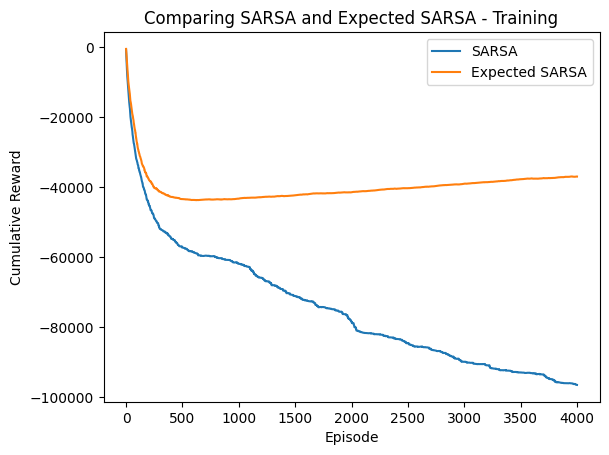

In [21]:
plt.title("Comparing SARSA and Expected SARSA - Training")
plt.plot(np.cumsum(train_s_rewards), label="SARSA")
plt.plot(np.cumsum(train_es_rewards), label="Expected SARSA")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()

_Training modified w/ action masks:_

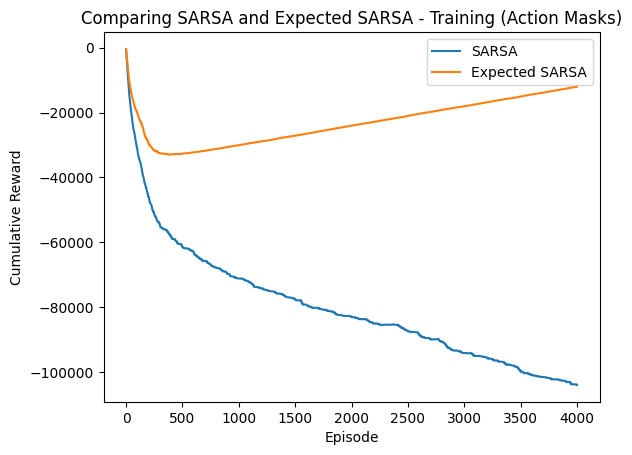

In [22]:
plt.title("Comparing SARSA and Expected SARSA - Training (Action Masks)")
plt.plot(np.cumsum(train_sm_rewards), label="SARSA")
plt.plot(np.cumsum(train_esm_rewards), label="Expected SARSA")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()

_Testing runs:_

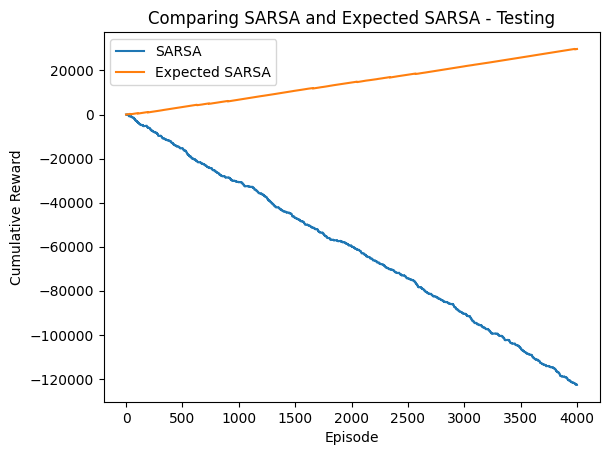

In [23]:
plt.title("Comparing SARSA and Expected SARSA - Testing")
plt.plot(np.cumsum(test_s_rewards), label="SARSA")
plt.plot(np.cumsum(test_es_rewards), label="Expected SARSA")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()

_Testing modified w/ action masks:_

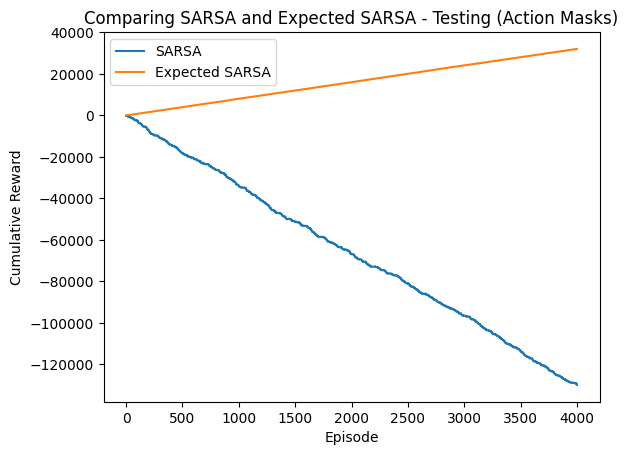

In [24]:
plt.title("Comparing SARSA and Expected SARSA - Testing (Action Masks)")
plt.plot(np.cumsum(test_sm_rewards), label="SARSA")
plt.plot(np.cumsum(test_esm_rewards), label="Expected SARSA")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()

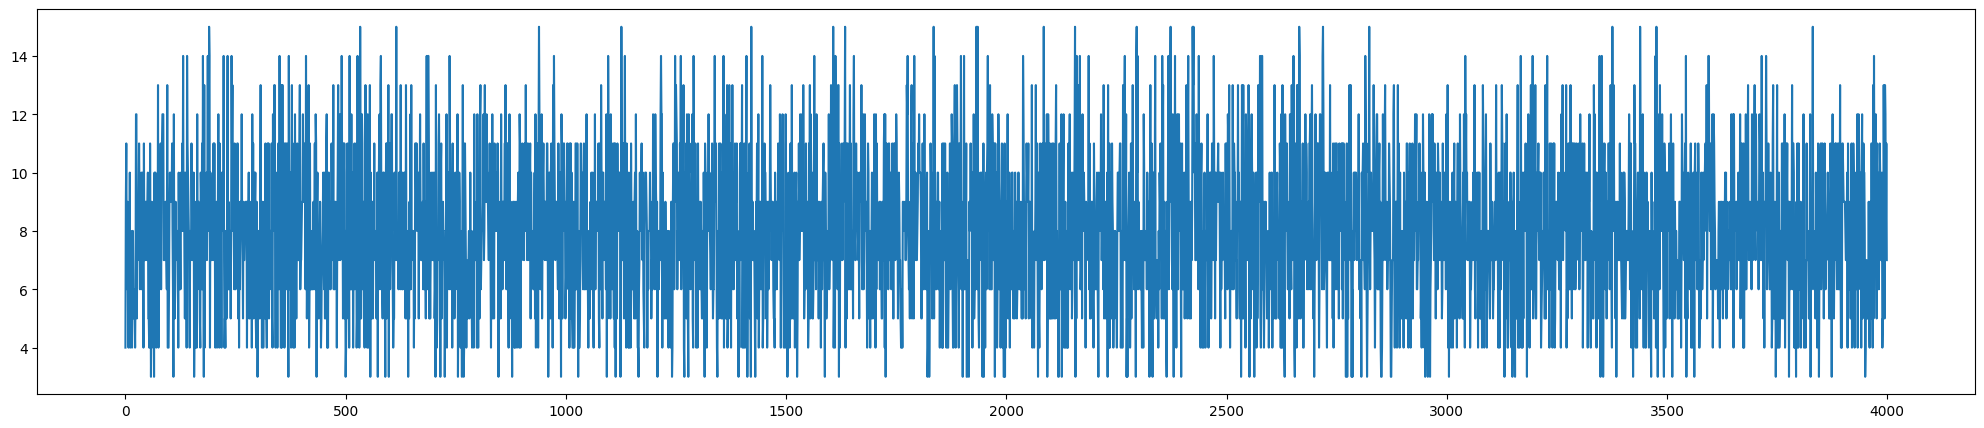

In [25]:
plt.figure(figsize=(25,5))
plt.plot(test_esm_rewards, label="Expected SARSA")

_As we can observe from the graphs, expected SARSA provides better results, most likely due to the quality estimations coming from a distribution of all possible future actions and not the best action._

_Closing the environment:_

In [33]:
env.close()